# Image Processing Overview

This is a (very) brief overview of key image processing terms for pathologists interested in digital pathology.

Here, I have used [NumPy](https://numpy.org), [SciPy](https://scipy.org) and [scikit-image](https://scikit-image.org) for image processing.
Thanks to [Jupyter Book](https://jupyterbook.org), the {guilabel}`Click to show` buttons can be used to view the original Python code used to generate each image.

> The example Ki67 image is extracted from OS-2.ndpi.
> The original whole slide image is part of the OpenSlide freely-distributed data (https://openslide.org).

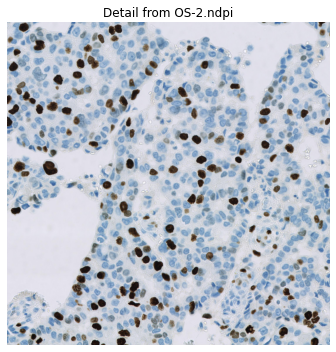

In [1]:
"""
Imports and helper functions used below.
"""

from imageio import imread
from matplotlib import pyplot as plt
import numpy as np
from typing import Iterable
from scipy import ndimage
import skimage


def rescale_percentiles(im, clip_percentile) -> np.ndarray:
    """
    Helper function to rescale a single channel image between 0 and 1, clipping by a specified percentile
    (both at the upper and lower bound).
    This is useful as a contrast adjustment method for an image intended only for display.
    """
    vmin = np.percentile(im, clip_percentile)
    vmax = np.percentile(im, 100-clip_percentile)
    return np.clip((im - vmin) / (vmax - vmin), 0, 1)


def colorize(im: np.ndarray, color: Iterable) -> np.ndarray:
    """
    Helper function to convert a single-channel image into a colorized (RGB) version.
    The color is expected to be a tuple with three values between 0 and 1 (for red, green and blue respectively).
    """
    return np.atleast_3d(im) * np.asarray(color).reshape((1, 1, 3))


def show_images(images, figheight=3, clip_percentile=None, cmap='gray', do_plot=True, n_rows=1, **kwargs):
    """
    Helper function to plot multiple images in a figure, in a standardized way.
    """
    n = len(images)
    figure = plt.figure(figsize=(figheight*n, figheight))
    counter = 0
    n_cols = n // n_rows
    for name, im in images.items():
        counter += 1
        plt.subplot(n_rows, n_cols, counter)
        if clip_percentile and im.dtype != bool:
            vmin = np.percentile(im, clip_percentile)
            vmax = np.percentile(im, 100-clip_percentile)
            plt.imshow(im, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
        else:
            plt.imshow(im, cmap=cmap, **kwargs)
        if name:
            plt.title(name)
        plt.axis(False)
    plt.tight_layout()
    if do_plot:
        plt.show()


def label2rgb(labs, random_colors=False, **kwargs) -> np.ndarray:
    """
    Wrapper around skimage.color.label2rgb to optionally generate more random colours.
    """
    n = labs.max()
    if random_colors:
        colors = np.random.random((n, 3))
    else:
        colors = None
    return skimage.color.label2rgb(labs, colors=colors, **kwargs)


def mark_rois(im, labs) -> np.ndarray:
    """
    Helper function to mark ROIs on top of an image using the provided labels.
    """

    # If we have a binary image, label it first
    if labs.dtype == bool:
        labs, n = ndimage.label(labs)

    # Find the boundaries
    bw_boundaries = skimage.segmentation.find_boundaries(labs)

    # Expand labels by one pixel into the background to make boundaries thicker
    labs_max = ndimage.maximum_filter(labs, 3)
    labs[labs == 0] = labs_max[labs == 0]

    # Convert labels to RGB
    lab_rgb = label2rgb(labs)

    # Ensure we have an RGB image
    im_rgb = im.copy()
    if im_rgb.ndim == 2 or im_rgb.shape[2] == 1:
        im_rgb = np.dstack((im_rgb, im_rgb, im_rgb))

    # Ensure range 0-1
    if im_rgb.dtype == np.uint8:
        im_rgb = im_rgb.astype(np.float32) / 255.0

    # Update each contour
    for ii in range(3):
        im_temp = im_rgb[:, :, ii]
        lab_temp = lab_rgb[:, :, ii]
        im_temp[bw_boundaries] = lab_temp[bw_boundaries]
    return im_rgb


# Show the image
im = imread('OS-2-ndpi-detail.png')
show_images({'Detail from OS-2.ndpi': im}, figheight=5)

## Digital image fundamentals


### Digital image

A **digital image** is essentially an array of numbers, where each number corresponds to a **pixel** (from **pic**ture **el**ement).

The pixels are visualized using a colour defined in a **lookup table** (sometimes referred to as a **colormap**).

Often, the lookup table simply uses shades of gray with black matching the lowest values and white matching the highest values.
However, different lookup tables can be used to visualize the same pixel values, thereby giving a different appearance to the image while keeping the raw data unchanged.

#### Example

A small digital image, expanded to display pixel values using a standard 'grayscale' lookup table (top) and the 'viridis' lookup table (bottom).

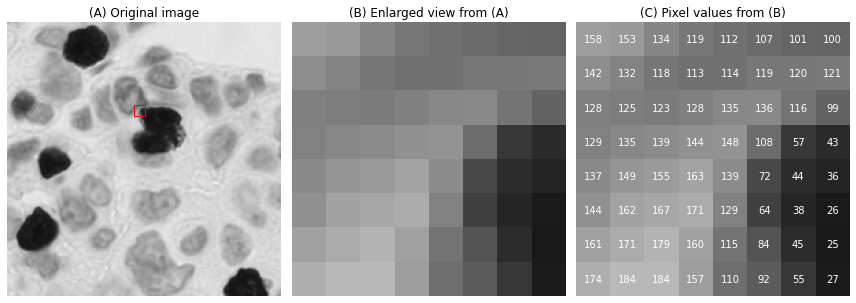

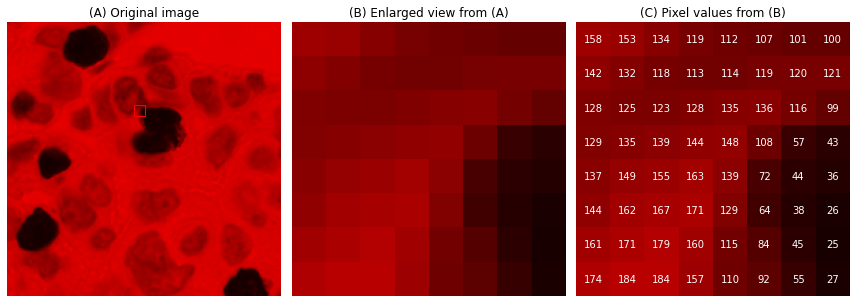

In [2]:
# Create a grayscale image
im = imread('OS-2-ndpi-detail.png').mean(axis=-1).astype(np.uint8)[:200, :200]

from matplotlib.colors import LinearSegmentedColormap
for cmap in ['gray', LinearSegmentedColormap.from_list('red', [(0, 0, 0), (1, 0, 0)])]:

    # Select a detailed region to enlarge
    x, y, width, height = (92, 60, 8, 8)
    im_detail = im[y:y+height, x:x+width]

    # Show the image, the enlarged region, and the pixel values superimposed on the enlarged region
    fig = plt.figure(figsize=(12, 6))
    import matplotlib.patches as patches
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

    plt.subplot(1, 3, 1)
    plt.imshow(im, vmin=0, vmax=255, cmap=cmap)
    plt.title('(A) Original image')
    plt.axis(False)
    plt.gca().add_patch(rect)

    plt.subplot(1, 3, 2)
    plt.imshow(im_detail, vmin=0, vmax=255, cmap=cmap)
    plt.axis(False)

    plt.title('(B) Enlarged view from (A)')

    plt.subplot(1, 3, 3)
    plt.imshow(im_detail, vmin=0, vmax=255, alpha = 1, cmap=cmap)
    plt.title('(C) Pixel values from (B)')
    plt.axis(False)
    for (i, j), z in np.ndenumerate(im_detail):
        c = 'white'
        plt.text(j, i, str(z), ha='center', va='center', color=c, fontdict={'size': 10})

    plt.tight_layout()
    plt.show()

### RGB image

An **RGB image** is a digital image in which three values are associated with each pixel: one each for **red**, **green**, and **blue**.

These colours are added together to give the final colour used to display the pixel.

##### Example

An RGB image split to give three separate images, corresponding to the red, green and blue channels respectively.
Each separated channel is shown with a lookup table that matches the corresponding colour.

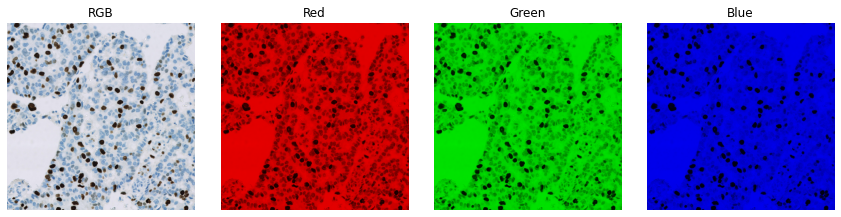

In [3]:
im = imread('OS-2-ndpi-detail.png')

# Define the red, green and blue colors
RED   = (1, 0, 0)
GREEN = (0, 1, 0)
BLUE  = (0, 0, 1)

# Strip out the red, green & blue channels and apply the
im_red = colorize(im[..., 0], RED)
im_green = colorize(im[..., 1], GREEN)
im_blue = colorize(im[..., 2], BLUE)

# Add the RGB images together (we'll get what we started with)
im_rgb = im_red + im_green + im_blue

# Show the RGB image alongside colorized versions of each channel
show_images(
    dict(
        RGB=im_rgb,
        Red=im_red,
        Green=im_green,
        Blue=im_blue,
        )
)

### Single-channel image

A **single-channel image** is one in which each pixel just has a single value.

It is common to convert an RGB image (three channels) into a single-channel image during processing.
There are many ways to do this, e.g.
* Simply select one of the RGB values (i.e. extract a single channel, as shown above)
* Compute a simple average (mean) of the RGB values
* Compute a weighted average of the RGB values

> A justification often given for using a weighted mean is that human perception does not afford equal weights to all the colours.

#### Example

Visualizing an RGB image converted to single-channel by averaging RGB values.
The mean and weighted mean images look similar, but subtracting corresponding pixels reveals that the values are not identical.

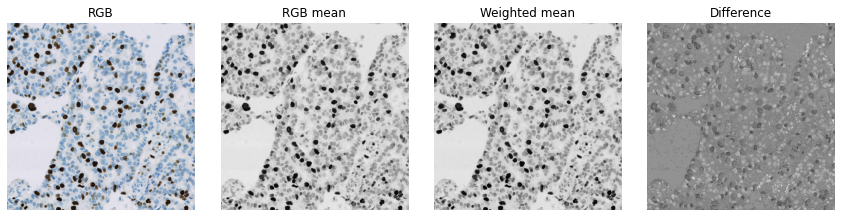

In [4]:
# Read the image
# For comparison with skimage output, first rescale to the range 0-1
im = imread('OS-2-ndpi-detail.png').astype(np.float32) / 255.0

# Compute the mean of RGB values
im_mean = im.mean(axis=-1)

# Use scikit-image for weighted conversion
# See https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html
im_weighted = skimage.color.rgb2gray(im)

# Show results and the difference
show_images(
    {'RGB': im, 'RGB mean': im_mean, 'Weighted mean': im_weighted, 'Difference': im_mean - im_weighted}, cmap='gray'
)

### Colour deconvolution

**Colour deconvolution** is a method of digital stain separation, first published by A. C. Ruifrok and D. A. Johnston [^fn_1], that is commonly used in digital pathology to split an RGB image into up to three single-channel images based upon stain colour.

[^fn_1]: Ruifrok AC, Johnston DA. Quantification of histochemical staining by color deconvolution. Anal Quant Cytol Histol. 2001 Aug;23(4):291-9. PMID: 11531144.

Colour deconvolution is calculated using **stain vectors**.
Each stain vector comprises 3 numbers, which relate to the RGB values that characterise the colour of a single stain in the image.
These values are normalized to be independent of stain intensity.

> Note that colour deconvolution is not the only approach to stain separation in digital pathology.
> While relatively straightforward to apply and practically very useful, colour deconvolution often produces 'impossible' results (e.g. imperfect images or stain vectors can result in negative stain values), which must be taking into consideration for any quantification.


#### Example

Stain separation using colour deconvolution.
Here, default stain vectors for hematoxylin (blue) and DAB (brown) are used with the colour deconvolution implementation found in scikit-image.

This already gives a subjectively reasonable separation of the blue and brown pixels.
The separation could nevertheless be improved by using stain vectors derived from the pixel values of the image itself.
Note also that the strongly positive (brown) pixels also have higher values in the 'hematoxylin' image.

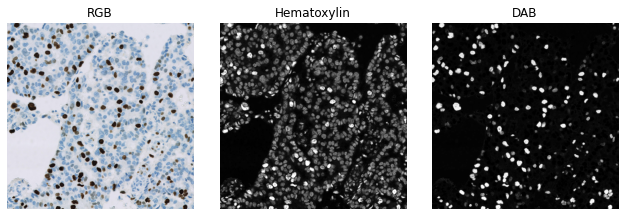

In [5]:
im = imread('OS-2-ndpi-detail.png')

# Use the default stain vectors and implementation from scikit-image
# Note that this is not at all optimal for the current image!
im_deconv = skimage.color.separate_stains(im, skimage.color.hdx_from_rgb)

im_hematoxylin = im_deconv[..., 0]
im_dab = im_deconv[..., 1]

show_images(
    {'RGB': im,
     'Hematoxylin': rescale_percentiles(im_hematoxylin, 1),
     'DAB': rescale_percentiles(im_dab, 1)
    }, cmap='gray'
)

### Multichannel image

A **multichannel image** is similar to an RGB image, except that it may have any number of channels - which are not necessarily viewed using red, green and blue lookup tables.

Multichannel images have been common in fluorescence microscopy for a long time.
Techniques such as *imaging mass cytometry* can routinely generate multichannel images with >40 channels.

#### Example

Illustration of a multichannel image with two channels.
Here, the channels are simply those generated previously by colour deconvolution - but assigned different lookup tables for visualization.

> Note that merging the colour deconvolved channels in this way does not produce the original RGB image.

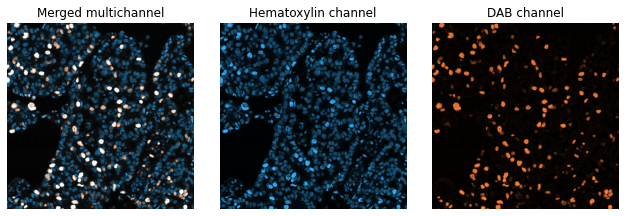

In [6]:
# Convert to an RGB version so we can visualize the result
im_h_color = colorize(rescale_percentiles(im_hematoxylin, 1), [0.2, 0.7, 1])
im_dab_color = colorize(rescale_percentiles(im_dab, 1), [1, 0.5, 0.2])

show_images(
    {
        'Merged multichannel': np.clip(im_h_color + im_dab_color, 0, 1),
        'Hematoxylin channel': im_h_color,
        'DAB channel': im_dab_color
    }
)

### Binary image

A **binary image** contains pixels with at most two different values, typically corresponding to **background** and **foreground**.

Binary images are often generated in an image processing workflow when detecting **objects**, i.e. structures of interest within the image.

#### Example

Three different binary images, derived by applying a **threshold** to the same input image.
Pixels with values above the threshold are classified as foreground (white) and pixels less than or equal to the threshold are classified as background (black).

The choice of threshold has a substantial impact upon the size, shape and number of objects detected.
Note also that a threshold alone does not do a good job of detecting nuclei here: more processing operations are needed.

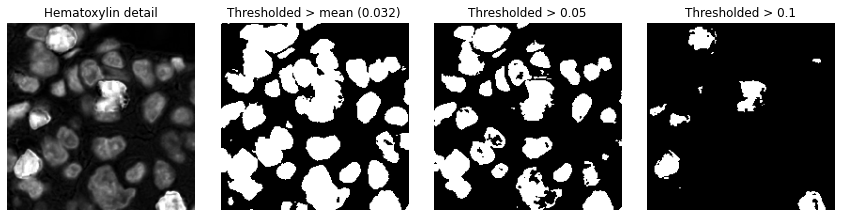

In [7]:
# Extract a small detail from the original & colour deconvolved images
im_detail = im[:200, :200]
im_h_detail = im_hematoxylin[:200, :200]
im_dab_detail = im_dab[:200, :200]

# Create a dict of thresholded images (plus the original first)
thresholded_images = {
    f'Hematoxylin detail': rescale_percentiles(im_h_detail, 1),
    f'Thresholded > mean ({im_hematoxylin.mean():.2})': im_h_detail > im_hematoxylin.mean(),
    'Thresholded > 0.05': im_h_detail > 0.05,
    'Thresholded > 0.1': im_h_detail > 0.1
}

show_images(thresholded_images, cmap='gray')

### Labelled image

A **labelled image** is similar to a binary image, except that distinct *foreground* objects each have their own unique integer label.
This makes it possible to distinguish between different objects, not simply foreground and background.

#### Example

Three labelled images, derived from the binary images above.
These are created by tracing **connected components** within the binary image, i.e. connected groups of foreground pixels.

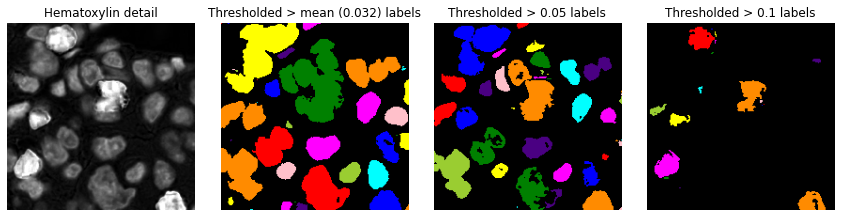

In [8]:
# Take thresholded images from before, and label the objects
labelled_images = {}
for name, im in thresholded_images.items():
    if im.dtype == bool:
        labelled_images[name + ' labels'] = label2rgb(ndimage.label(im)[0])
    else:
        labelled_images[name] = im

show_images(labelled_images, cmap='gray')

### Region of interest

**Regions of interest (ROIs)** provide an alternative to labelled images as a way to represent objects, or to define areas of interest that do not necessarily correspond to any particular structure (e.g. a region within which analysis should be applied).

> ROIs are often represented as polygons, although this depends upon the software being used.
> There is not always a clear distinction between a ROI and an object, and a ROI may also be represented using a binary or labelled image.

#### Example

Generating region of interest polygons from the labelled images above, to visualize detected objects more clearly on top of the original image.

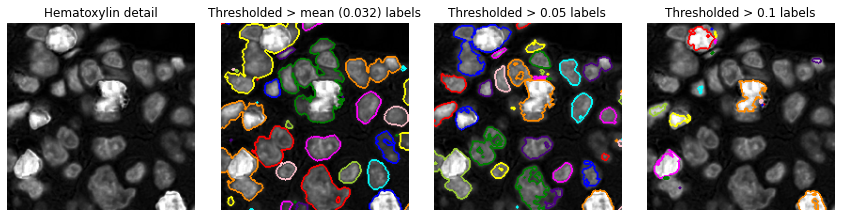

In [9]:
roi_images = {}
for name, im in thresholded_images.items():
    if im.dtype == bool:
        roi_images[name + ' labels'] = mark_rois(rescale_percentiles(im_h_detail, 1), ndimage.label(im)[0])
    else:
        roi_images[name] = im

show_images(roi_images, cmap='gray')

## Image filters

### Linear filters

A **linear filter** replaces every pixel values in an image by a **weighted sum** of the surrounding pixel values.

Applying a linear filter is often called **convolution** and the weights are defined using a **convolution kernel**.

#### Example

The result of applying three different 3x3 convolution kernels are shown:
* **3x3 Mean** - calculates the mean of each pixel and its immediate neighbors; used for smoothing
* **3x3 Sobel** - approximates a vertical gradient; used to enhance horizontal edges
* **3x3 Laplacian** - approximates a second derivative; used to enhance spots and edges

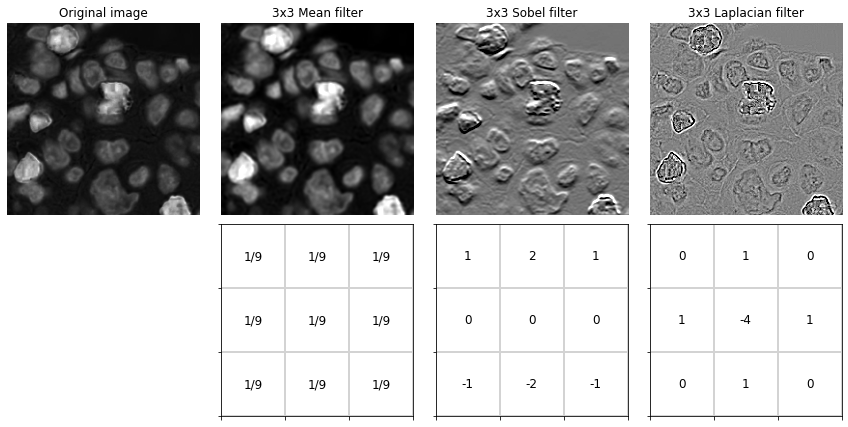

In [10]:
# Define three convolution kernels
kernel_mean3x3 = np.ones((3, 3)) / 9.0
kernel_sobel = np.asarray([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
kernel_laplacian = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

kernels = {
    '3x3 Mean filter': kernel_mean3x3,
    '3x3 Sobel filter': kernel_sobel,
    '3x3 Laplacian filter': kernel_laplacian    
}

# Plot images with kernels below
col = 0
n_rows = 2

n_cols = len(kernels) + 1
plt.figure(figsize=(12, 6))
plt.subplot(n_rows, n_cols, 1)
plt.imshow(im_h_detail, cmap='gray')
plt.title('Original image')
plt.axis(False)

for name, kernel in kernels.items():
    col += 1

    plt.subplot(n_rows, n_cols, col+1)
    plt.title(name)
    im_filtered = ndimage.convolve(im_h_detail, kernel)
    vmin = np.percentile(im_filtered, 1)
    vmax = np.percentile(im_filtered, 99)
    plt.imshow(im_filtered, vmin=vmin, vmax=vmax, cmap='gray')
    plt.axis(False)

    plt.subplot(n_rows, n_cols, n_cols+col+1)
    plt.imshow(np.ones(kernel.shape), vmin=0, vmax=1, alpha = 1, cmap='gray')
    plt.grid(which='major', axis='both', linestyle='-', color='lightgray', linewidth=2)
    plt.xticks(np.arange(4) - 0.5, labels=[])
    plt.yticks(np.arange(4) - 0.5, labels=[])
    for (i, j), z in np.ndenumerate(kernel):
        c = 'black'
        if kernel is kernel_mean3x3:
            plt.text(j, i, '1/9', ha='center', va='center', color=c, fontdict={'size': 12})
        else:
            plt.text(j, i, str(z), ha='center', va='center', color=c, fontdict={'size': 12})

plt.tight_layout()
plt.show()

kernel = np.asarray([-1, 0, 1]).reshape((1, -1))

### Gaussian filters

**Gaussian filters** are an especially important example of linear filters.

The kernel for a Gaussian filter is derived from a **Gaussian function**, and the filter size is controlled by a $\sigma$ value (a larger $\sigma$ results in more smoothing).
It effectively replaces each pixel by a weighted average of the surrounding pixel values, with nearby pixels weighted more heavily.

#### Example

Applying Gaussian filters with increasing $\sigma$ values to an image.

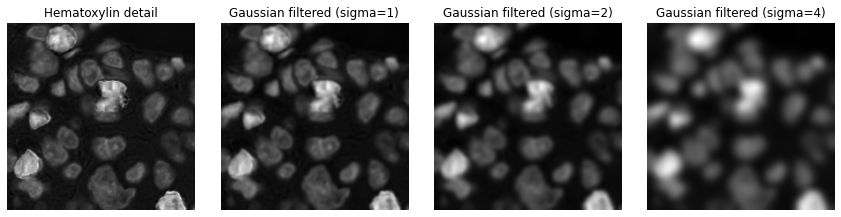

In [11]:
# Take thresholded images from before, and label the objects
show_images({
        'Hematoxylin detail': im_h_detail,
        'Gaussian filtered (sigma=1)': ndimage.gaussian_filter(im_h_detail, 1),
        'Gaussian filtered (sigma=2)': ndimage.gaussian_filter(im_h_detail, 2),
        'Gaussian filtered (sigma=4)': ndimage.gaussian_filter(im_h_detail, 4)
    }, cmap='gray')

### Non-linear filters

**Non-linear filters** replace each pixel value based upon some calculation *other* than a weighted sum.


### Rank filters

Perhaps the most common non-linear filters for image processing are the **rank filters**.

These effectively rank the pixels within an *n x n* neighbourhood according to value, and then select one of the values as output depending upon the filter type - usually the **median**, **minimum** or **maximum**.


#### Example

Applying three different rank filters to an input image.
Each output pixel is determined from a 9x9 square neighbourhood centred on the corresponding input pixel.

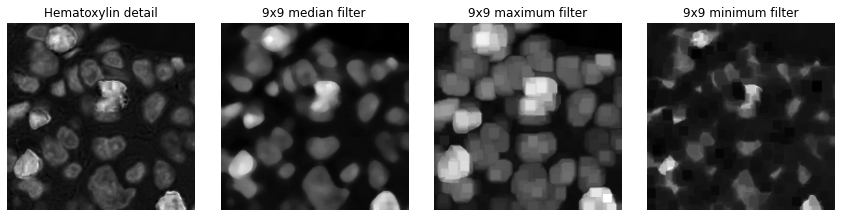

In [12]:
show_images({
        'Hematoxylin detail': im_h_detail,
        '9x9 median filter': ndimage.median_filter(im_h_detail.astype(np.float32), 9),
        '9x9 maximum filter': ndimage.maximum_filter(im_h_detail.astype(np.float32), 9),
        '9x9 minimum filter': ndimage.minimum_filter(im_h_detail.astype(np.float32), 9)
    }, cmap='gray')

## Image transforms

### Distance transform

The **distance transform** is applied to a binary image.
It generates a **distance map**, in which each pixel value represents the distance to the nearest background pixel in the original binary image.

This results in higher values towards the centre of structures, and smaller values towards the boundary.

#### Example

The distance transform of a binary image, which had been generated by thresholding an image after Gaussian filtering.

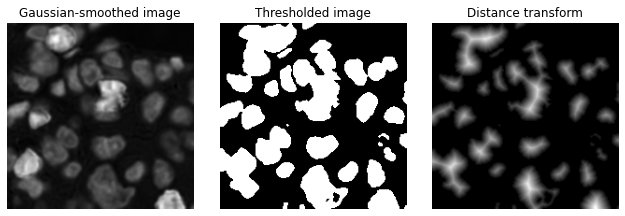

In [13]:
im_smoothed = ndimage.gaussian_filter(im_h_detail, 1)
bw = im_smoothed > im_smoothed.mean()
bw_dist = ndimage.distance_transform_edt(bw)

show_images({
    'Gaussian-smoothed image': im_smoothed,
    'Thresholded image': bw,
    'Distance transform': bw_dist
    }, cmap='gray')

### Watershed transform

The **watershed transform** is a region-growing transform that can be used to separate objects.

If the watershed transform is applied to a distance map generated from a binary image, it can be useful to split ‘roundish’ structures that were merged in the binary image.

In this case, a labelled image is first created containing seed labels - which correspond to pixels with high distance values, i.e. they occur towards object centres.
These seeds are progressively expanded, until they reach either the background or a nearby expanding labels.

#### Example

A watershed transform is applied to the output for the distance transform applied previously.
Note that some (although not all) of the connected components in the binary image could be separated using this approach.

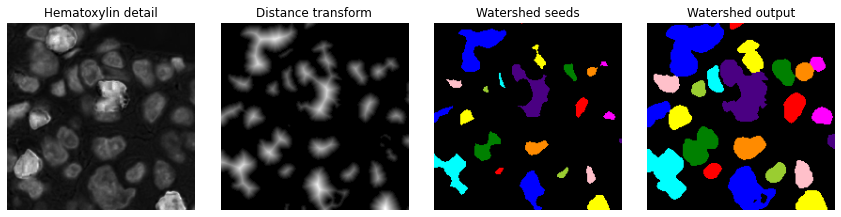

In [14]:
im_seeds = ndimage.label(bw_dist > 5)[0]
bw_seeds = bw_dist > 5
im_seeds = ndimage.label(bw_seeds)[0]
im_watershed = skimage.segmentation.watershed(-bw_dist, im_seeds, mask=bw_dist > 0)

show_images({
    'Hematoxylin detail': im_h_detail,
    'Distance transform': bw_dist,
    'Watershed seeds': label2rgb(im_seeds),
    'Watershed output': label2rgb(im_watershed)
    }, cmap='gray')

## Composing workflows

Equipped with these core tools, it is already possible to assemble image processing **workflows** (i.e. **algorithms**) for specific purposes.

For example, a simple workflow to detect nuclei might include:

* Convert the RGB image to have a single channel
  * e.g. by taking the mean of RGB values
* Smooth the image
  * e.g. by applying a small Gaussian filter, with $\sigma$ = 1
* Threshold the image
  * e.g. using its mean value as a threshold
* Convert binary regions to ROIs for visualization

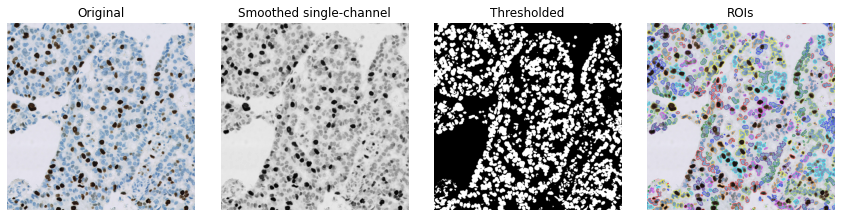

In [15]:
im = imread('OS-2-ndpi-detail.png')

# Convert to grayscale (mean RGB channels)
im_g = im.mean(axis=-1)

# Smooth with a small Gaussian filter
im_g = ndimage.gaussian_filter(im_g, 1)

# Threshold (here, we just use the mean... but could use something else)
bw = im_g < im_g.mean()

show_images({
    'Original': im,
    'Smoothed single-channel': im_g,
    'Thresholded': bw,
    'ROIs': mark_rois(im, bw)
})

Even here, we could vary three different things, potentially getting different results:

* the method of converting to a single channel
* the method of smoothing
* the threshold value

However, in practice, simple workflows like this tend to only give reasonable-looking results on a few images and/or when viewed at a low magnification.
Errors are evident when viewed at a higher resolution, indicating that much more sophisticated workflows with required - generally with many more adjustable parameters.

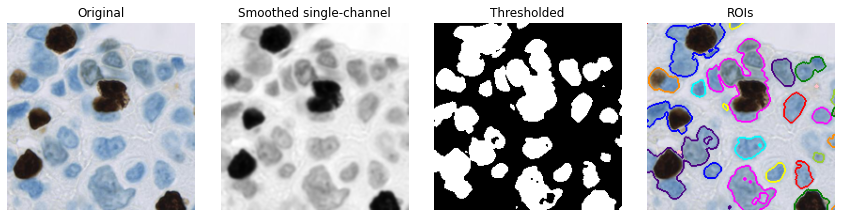

In [16]:
im = im_detail.copy()

# Convert to grayscale (mean RGB channels)
im_g = im.mean(axis=-1)

# Smooth with a small Gaussian filter
im_g = ndimage.gaussian_filter(im_g, 1)

# Threshold (here, we just use the mean... but could use something else)
bw = im_g < im_g.mean()

show_images({
    'Original': im,
    'Smoothed single-channel': im_g,
    'Thresholded': bw,
    'ROIs': mark_rois(im, bw)
})